<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/LanguageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This classifier identifies the native language of the speaker from an English reading.

Only the top 10 langauges (in addition to English) from the Speech Sample archive are included.





Remaining steps:

Load the VGGish model.

Create dataset generators to process the files in batches. The data generator runs the segments through the VGGish model and extract the feature embeddings, which are used as input to the classifier model. Also, will need to encode labels as one-hot vectors, and figure out how to load from various folders in the train, validation and test directories.

The classifier will return the native langauge of the speaker, from a list of 10 (plus English).

In [ ]:
# Set up the environment
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import soundfile as sf

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub

from keras.layers import Dense, Input
from keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [ ]:
#https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
augment     genderClf_3layer  models		   recordings
data	    kaggle.json       processed.csv	   speakers_all.csv
genderClf1  model	      reading-passage.txt


In [ ]:
# Import custom functions that I wrote
import augment
from augment import Augment

from imp import reload

Module imported
Augment scripts reloaded


In [ ]:
# Set constants
SAMP_RATE = 16000  #Defined in augment package
BATCH_SIZE = 32  #Defined in augment package
CLF = 'lang10'

In [ ]:
meta = pd.read_csv('processed.csv', index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


## Extract native English speakers
Downsample the number of speakers, but keep the some of the variation in the distribution of countries.



In [ ]:
# Create dataframe of only native English speakers
english = meta.loc[meta.native_language == 'english']
# Look at the counts of countries
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
south africa              4
singapore                 4
panama                    3
india                     3
malaysia                  2
philippines               2
guyana                    2
pakistan                  1
united arab emirates      1
fiji                      1
italy                     1
us virgin islands         1
germany                   1
antigua and barbuda       1
barbados                  1
bolivia                   1
switzerland               1
nigeria                   1
trinidad                  1
lebanon                   1
the bahamas               1
papua new guinea          1
ghana                     1
spain                     1
belize                    1
virginia                  1
liberia                   1
isle of man               1
Name: country, dtype

In [ ]:
# Convert country counts to weights for use in the random sampling function
eng_country_pct = english.country.value_counts(normalize=True)
eng_country_pct

usa                     0.644214
uk                      0.112263
canada                  0.075993
australia               0.055268
ireland                 0.018998
new zealand             0.013817
jamaica                 0.008636
south africa            0.006908
singapore               0.006908
panama                  0.005181
india                   0.005181
malaysia                0.003454
philippines             0.003454
guyana                  0.003454
pakistan                0.001727
united arab emirates    0.001727
fiji                    0.001727
italy                   0.001727
us virgin islands       0.001727
germany                 0.001727
antigua and barbuda     0.001727
barbados                0.001727
bolivia                 0.001727
switzerland             0.001727
nigeria                 0.001727
trinidad                0.001727
lebanon                 0.001727
the bahamas             0.001727
papua new guinea        0.001727
ghana                   0.001727
spain     

In [ ]:
english = english.join(eng_country_pct, how = 'left', on='country', rsuffix='_weight')

In [ ]:
# Calculate country weights for random sampling, put in 'country_pct' column
english['country_pct'] = english['country_weight']/sum(english['country_weight'])

In [ ]:
#  Find random seed that will provide the highest number of country samples
max_count = 0
max_idx = 0
for i in range(200):
  eng_samp_inx = english.sample(100, replace=False, weights=english.country_pct, random_state=i)
  count = eng_samp_inx.country.nunique()
  if max_count  < count:
    max_count = count
    max_idx = i

print(max_idx, max_count)

26 6


In [ ]:
eng_samples = english.sample(100, replace=False, weights=english.country_pct , random_state=max_idx)
eng_samples.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?,country_weight,country_pct
speakerid,,,,,,,,,,
586,68.0,0.0,"new eagle, pennsylvania, usa",english181,english,male,usa,False,0.644214,0.002544
1120,26.0,0.0,"memphis, tennessee, usa",english314,english,female,usa,False,0.644214,0.002544
1554,37.0,0.0,"lancashire, leyland, uk",english456,english,female,uk,False,0.112263,0.000443
1640,30.0,0.0,"myrtle beach, south carolina, usa",english468,english,male,usa,False,0.644214,0.002544
1884,47.0,0.0,"st. paul, minnesota, usa",english520,english,female,usa,False,0.644214,0.002544


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

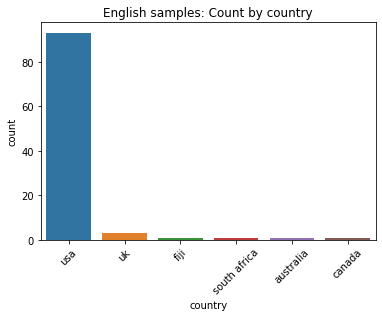

In [ ]:
sns.countplot(x='country', data=eng_samples)
plt.title('English samples: Count by country')
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

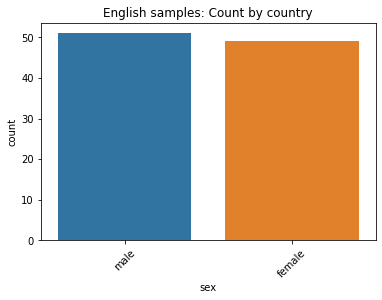

In [ ]:
# Check that gender is still roughly distributed equally
sns.countplot(x='sex', data=eng_samples)
plt.title('English samples: Count by country')
plt.xticks(rotation=45)

### Split English files into training, validation and testing sets

In [ ]:
eng_data = eng_samples[['filename','sex']]
x_train_names, x_test_names, y_train, y_test = train_test_split(
    eng_data['filename'], eng_data['sex'], test_size=0.25, random_state=38)

In [ ]:
x_train_names, x_val_names, y_train, y_val = train_test_split(
    x_train_names, y_train, test_size = 0.25, random_state=38)

In [ ]:
print("Number of training files: ", x_train_names.shape)
print("Number of training files: ", x_val_names.shape)
print("Number of testing files: ", x_test_names.shape)

Number of training files:  (56,)
Number of training files:  (19,)
Number of testing files:  (25,)


### Process English audio files and store in appropriate files

In [ ]:
# Check if training data has been segmented. If not, segment each audio file.
train_file_list = os.listdir('data/lang10/train/english')

for i in range(len(x_train_names)):
  # get a filename
  filename = x_train_names.iloc[i]
  # Check to see if the filename has already been segmented
  # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
  if any(file.startswith(filename) for file in train_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_train_names.iloc[i], y_train.iloc[i], split='train/english', clf=CLF)
    print('{} segmented'.format(filename))

In [ ]:
# Check if training data has been segmented. If not, segment each audio file.
val_file_list = os.listdir('data/lang10/validation/english')

for i in range(len(x_val_names)):
  # get a filename
  filename = x_val_names.iloc[i]
  # Check to see if the filename has already been segmented
  # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
  if any(file.startswith(filename) for file in val_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_val_names.iloc[i], y_val.iloc[i], split='validation/english', clf=CLF)
    print('{} segmented'.format(filename))

In [ ]:
# Check if testing data has been segmented. If not, segment each audio file.
test_file_list = os.listdir('data/lang10/test/test_data')
for i in range(len(x_test_names)):
  filename = x_test_names.iloc[i]
  # if any(file.startswith(filename) for file in os.listdir('data/gender/test')):
  if any(file.startswith(filename) for file in test_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_test_names.iloc[i], y_test.iloc[i], split='test/test_data', clf=CLF)
    print('{} segmented'.format(filename))

## Get top 10 languages after English.

In [ ]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [ ]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]

In [ ]:
top_lang.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
11,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,saudi arabia,False
12,26.0,5.0,"cairo, egypt",arabic10,arabic,male,egypt,False
13,30.0,14.0,"monastir, tunisia",arabic11,arabic,female,tunisia,False
14,32.0,11.0,"baghdad, iraq",arabic12,arabic,male,iraq,False
15,25.0,15.0,"zabbougha, lebanon",arabic13,arabic,male,lebanon,False


## Split the data by language

In [ ]:
# Split Spanish data
spanish = meta.loc[meta.native_language == 'spanish']
spanish_train_names, spanish_test_names, spanish_y_train, spanish_y_test = train_test_split(
    spanish['filename'], spanish['sex'], test_size=0.25, random_state=38)
spanish_train_names, spanish_val_names, spanish_y_train, spanish_y_val = train_test_split(
    spanish_train_names, spanish_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", spanish_train_names.shape)
print("Number of training files: ", spanish_val_names.shape)
print("Number of testing files: ", spanish_test_names.shape)

Number of training files:  (90,)
Number of training files:  (31,)
Number of testing files:  (41,)


In [ ]:
# Split Arabic data
arabic = meta.loc[meta.native_language == 'arabic']
arabic_train_names, arabic_test_names, arabic_y_train, arabic_y_test = train_test_split(
    arabic['filename'], arabic['sex'], test_size=0.25, random_state=38)
arabic_train_names, arabic_val_names, arabic_y_train, arabic_y_val = train_test_split(
    arabic_train_names, arabic_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", arabic_train_names.shape)
print("Number of training files: ", arabic_val_names.shape)
print("Number of testing files: ", arabic_test_names.shape)

Number of training files:  (57,)
Number of training files:  (19,)
Number of testing files:  (26,)


In [ ]:
# Split Mandarin data
mandarin = meta.loc[meta.native_language == 'mandarin']
mandarin_train_names, mandarin_test_names, mandarin_y_train, mandarin_y_test = train_test_split(
    mandarin['filename'], mandarin['sex'], test_size=0.25, random_state=38)
mandarin_train_names, mandarin_val_names, mandarin_y_train, mandarin_y_val = train_test_split(
    mandarin_train_names, mandarin_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", mandarin_train_names.shape)
print("Number of training files: ", mandarin_val_names.shape)
print("Number of testing files: ", mandarin_test_names.shape)

Number of training files:  (36,)
Number of training files:  (12,)
Number of testing files:  (17,)


In [ ]:
# Split French data
french = meta.loc[meta.native_language == 'french']
french_train_names, french_test_names, french_y_train, french_y_test = train_test_split(
    french['filename'], french['sex'], test_size=0.25, random_state=38)
french_train_names, french_val_names, french_y_train, french_y_val = train_test_split(
    french_train_names, french_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", french_train_names.shape)
print("Number of training files: ", french_val_names.shape)
print("Number of testing files: ", french_test_names.shape)

Number of training files:  (35,)
Number of training files:  (12,)
Number of testing files:  (16,)


In [ ]:
# Split Korean data
korean = meta.loc[meta.native_language == 'korean']
korean_train_names, korean_test_names, korean_y_train, korean_y_test = train_test_split(
    korean['filename'], korean['sex'], test_size=0.25, random_state=38)
korean_train_names, korean_val_names, korean_y_train, korean_y_val = train_test_split(
    korean_train_names, korean_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", korean_train_names.shape)
print("Number of training files: ", korean_val_names.shape)
print("Number of testing files: ", korean_test_names.shape)

Number of training files:  (29,)
Number of training files:  (10,)
Number of testing files:  (13,)


In [ ]:
# Split Russian data
russian = meta.loc[meta.native_language == 'russian']
russian_train_names, russian_test_names, russian_y_train, russian_y_test = train_test_split(
    russian['filename'], russian['sex'], test_size=0.25, random_state=38)
russian_train_names, russian_val_names, russian_y_train, russian_y_val = train_test_split(
    russian_train_names, russian_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", russian_train_names.shape)
print("Number of training files: ", russian_val_names.shape)
print("Number of testing files: ", russian_test_names.shape)

Number of training files:  (27,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [ ]:
# Split Portuguese data
portuguese = meta.loc[meta.native_language == 'portuguese']
portuguese_train_names, portuguese_test_names, portuguese_y_train, portuguese_y_test = train_test_split(
    portuguese['filename'], portuguese['sex'], test_size=0.25, random_state=38)
portuguese_train_names, portuguese_val_names, portuguese_y_train, portuguese_y_val = train_test_split(
    portuguese_train_names, portuguese_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", portuguese_train_names.shape)
print("Number of training files: ", portuguese_val_names.shape)
print("Number of testing files: ", portuguese_test_names.shape)

Number of training files:  (27,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [ ]:
# Split Dutch data
dutch = meta.loc[meta.native_language == 'dutch']

dutch_train_names, dutch_test_names, dutch_y_train, dutch_y_test = train_test_split(
    dutch['filename'], dutch['sex'], test_size=0.25, random_state=38)
dutch_train_names, dutch_val_names, dutch_y_train, dutch_y_val = train_test_split(
    dutch_train_names, dutch_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", dutch_train_names.shape)
print("Number of training files: ", dutch_val_names.shape)
print("Number of testing files: ", dutch_test_names.shape)

Number of training files:  (26,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [ ]:
# Split Turkish data
turkish = meta.loc[meta.native_language == 'turkish']
turkish_train_names, turkish_test_names, turkish_y_train, turkish_y_test = train_test_split(
    turkish['filename'], turkish['sex'], test_size=0.25, random_state=38)
turkish_train_names, turkish_val_names, turkish_y_train, turkish_y_val = train_test_split(
    turkish_train_names, turkish_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", turkish_train_names.shape)
print("Number of training files: ", turkish_val_names.shape)
print("Number of testing files: ", turkish_test_names.shape)

Number of training files:  (20,)
Number of training files:  (7,)
Number of testing files:  (10,)


In [ ]:
# Split German data
german = meta.loc[meta.native_language == 'german']
german_train_names, german_test_names, german_y_train, german_y_test = train_test_split(
    german['filename'], german['sex'], test_size=0.25, random_state=38)
german_train_names, german_val_names, german_y_train, german_y_val = train_test_split(
    german_train_names, german_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", german_train_names.shape)
print("Number of training files: ", german_val_names.shape)
print("Number of testing files: ", german_test_names.shape)

Number of training files:  (20,)
Number of training files:  (7,)
Number of testing files:  (9,)


In [ ]:
train_list = [spanish_train_names, arabic_train_names, mandarin_train_names, french_train_names, korean_train_names, 
             russian_train_names, portuguese_train_names, dutch_train_names, turkish_train_names, german_train_names]

y_train_list = [spanish_y_train, arabic_y_train, mandarin_y_train, french_y_train, korean_y_train, 
             russian_y_train, portuguese_y_train, dutch_y_train, turkish_y_train, german_y_train]

for lang, train, y_train in zip(lang_list, train_list, y_train_list):
  # Check if training data has been segmented. If not, segment each audio file.
  train_file_list = os.listdir('data/lang10/train/{}'.format(lang))

  for i in range(len(train)):
    # get a filename
    filename = train.iloc[i]
    # Check to see if the filename has already been segmented
    # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
    if any(file.startswith(filename) for file in train_file_list):
      pass
    else: 
     augment.Augment.segment_audio(train.iloc[i], y_train.iloc[i], split='train/{}'.format(lang), clf=CLF)
     #print('{} segmented'.format(filename))

In [ ]:
val_list = [spanish_val_names, arabic_val_names, mandarin_val_names, french_val_names, korean_val_names, 
             russian_val_names, portuguese_val_names, dutch_val_names, turkish_val_names, german_val_names]

y_val_list = [spanish_y_val, arabic_y_val, mandarin_y_val, french_y_val, korean_y_val, 
             russian_y_val, portuguese_y_val, dutch_y_val, turkish_y_val, german_y_val]

for lang, val, y_val in zip(lang_list, val_list, y_val_list):
  # Check if training data has been segmented. If not, segment each audio file.
  val_file_list = os.listdir('data/lang10/validation/{}'.format(lang))

  for i in range(len(val)):
    # get a filename
    filename = val.iloc[i]
    # Check to see if the filename has already been segmented
    # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
    if any(file.startswith(filename) for file in val_file_list):
      pass
    else: 
     augment.Augment.segment_audio(val.iloc[i], y_val.iloc[i], split='validation/{}'.format(lang), clf=CLF)
     #print('{} segmented'.format(filename))

In [ ]:
test_list = [spanish_test_names, arabic_test_names, mandarin_test_names, french_test_names, korean_test_names, 
             russian_test_names, portuguese_test_names, dutch_test_names, turkish_test_names, german_test_names]

y_test_list = [spanish_y_test, arabic_y_test, mandarin_y_test, french_y_test, korean_y_test, 
             russian_y_test, portuguese_y_test, dutch_y_test, turkish_y_test, german_y_test]

for lang, test, y_test in zip(lang_list, test_list, y_test_list):
  # Check if training data has been segmented. If not, segment each audio file.
  test_file_list = os.listdir('data/lang10/test/test_data')

  for i in range(len(test)):
    # get a filename
    filename = test.iloc[i]
    # Check to see if the filename has already been segmented
    # if any(file.startswith(filename) for file in os.listdir('data/gender/train')):
    if any(file.startswith(filename) for file in test_file_list):
      pass
    else: 
     augment.Augment.segment_audio(test.iloc[i], y_test.iloc[i], split='test/test_data', clf=CLF)
     #print('{} segmented'.format(filename))

###  Add noise to test and validation files

In [ ]:
# Generate a list training filenames + segment index to input to add_noise() function
train_dict = {}
val_dict = {}

for lang in lang_list:
  train_dict[lang] = [x.split('o.wav')[0] for x in os.listdir('data/lang10/train/{}'.format(lang)) if x.endswith('o.wav')]
  val_dict[lang] = [x.split('o.wav')[0] for x in os.listdir('data/lang10/validation/{}'.format(lang)) if x.endswith('o.wav')]

In [ ]:
# Check if training data has been augmented with noise. If not, add noise to each segment.
for key, val in train_dict.items():
  # print(type(val))
  noise_train_list = os.listdir('data/lang10/train/{}'.format(key))
  for i in range(len(val)):
    filename = val[i]
  
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_train_list):
      pass
    else: 
      augment.Augment.noisy_data(val[i], split='train/{}'.format(key), clf=CLF)
      #print('{} augmented'.format(filename))

In [ ]:
# Check if validation data has been augmented with noise. If not, add noise to each segment.
for key, val in val_dict.items():
  noise_train_list = os.listdir('data/lang10/validation/{}'.format(key))
  for i in range(len(val)):
    filename = val[i]
  
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_train_list):
      pass
    else: 
      augment.Augment.noisy_data(val[i], split='validation/{}'.format(key), clf=CLF)
      #print('{} augmented'.format(filename))

## Load the VGGish model
Needs to be instantiated before dataset generation can be done.

In [ ]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

# Works up to here

## Generate datasets
Following the example from https://keras.io/examples/audio/speaker_recognition_using_cnn/

In [ ]:
# Dataset generation from Keras.IO example
# https://keras.io/examples/audio/speaker_recognition_using_cnn/

from pathlib import Path
# Get the list of audio file paths along with their corresponding labels
DATASET_ROOT = "data/lang10"
TRAIN_SUBFOLDER = "train"
VAL_SUBFOLDER = "validation"
TEST_SUBFOLDER = "test/test_data"

DATASET_TRAIN_PATH = os.path.join(DATASET_ROOT, TRAIN_SUBFOLDER)
DATASET_VAL_PATH = os.path.join(DATASET_ROOT, VAL_SUBFOLDER)
DATASET_TEST_PATH = os.path.join(DATASET_ROOT, TEST_SUBFOLDER)

SHUFFLE_SEED = 38
SAMP_RATE = 16000

class_names = os.listdir(DATASET_TRAIN_PATH)
print("Our class names: {}".format(class_names,))

Our class names: ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 'portuguese', 'dutch', 'turkish', 'german', 'english']
Processing language spanish
Processing language arabic
Processing language mandarin
Processing language french
Processing language korean
Processing language russian
Processing language portuguese
Processing language dutch
Processing language turkish
Processing language german
Processing language english
Found 1929 files belonging to 11 classes.


In [ ]:
# Process training data
train_paths = []
train_labels = []
for label, name in enumerate(class_names):
    print("Processing language {}".format(name,))
    dir_path = Path(DATASET_TRAIN_PATH) / name
    language_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    train_paths += language_sample_paths
    train_labels += [label] * len(language_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

In [ ]:
print(train_labels[:2*BATCH_SIZE])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Process validation data
validation_paths = []
val_labels = []
for label, name in enumerate(class_names):
    print("Processing language {}".format(name,))
    dir_path = Path(DATASET_VAL_PATH) / name
    language_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    validation_paths += language_sample_paths
    val_labels += [label] * len(language_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(validation_paths), len(class_names))
)

Processing language spanish
Processing language arabic
Processing language mandarin
Processing language french
Processing language korean
Processing language russian
Processing language portuguese
Processing language dutch
Processing language turkish
Processing language german
Processing language english
Found 652 files belonging to 11 classes.


In [ ]:
# Process validation data
testing_paths = []
test_labels = []
for label, name in enumerate(class_names):
    print("Processing language {}".format(name,))
    dir_path = Path(DATASET_TEST_PATH) / name
    language_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    testing_paths += language_sample_paths
    test_labels += [label] * len(language_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(testing_paths), len(class_names))
)

In [ ]:
# Shuffle the order of the traning and validation datasets and labels
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(validation_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(val_labels)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(testing_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

In [ ]:
train_onehot = tf.keras.backend.one_hot(train_labels, num_classes = len(class_names))
val_onehot = tf.keras.backend.one_hot(val_labels, num_classes = len(class_names))
test_onehot = tf.keras.backend.one_hot(test_labels, num_classes = len(class_names))

print(type(train_onehot) )
print(train_onehot.shape)
print(train_onehot[0])

In [ ]:
# Print sizes of data splits
print("Number of training samples: ", len(train_paths))
print("Number of validation samples: ", len(validation_paths))
testing_paths = os.listdir('data/lang10/test/test_data')
print("Number of testing samples: ", len(testing_paths))

Number of training samples:  1929
Number of validation samples:  652
Number of testing samples:  446


In [ ]:
# Calculate how many dataset batches to generate
# May not be needed with this new generator. Still, I want to know how many steps per epoch
train_steps = np.int(np.ceil(len(train_paths)/BATCH_SIZE))
val_steps = np.int(np.ceil(len(validation_paths)/BATCH_SIZE))
eval_steps = np.int(np.ceil(len(testing_paths)/BATCH_SIZE))

print("training_steps_per_epoch = ", train_steps)
print("validation_steps = ", val_steps)
print("evaluation_steps = ", eval_steps)

steps_per_epoch =  61
validation_steps =  21
evaluation_steps =  14


## Dataset generator

In [ ]:
def tf_data_generator(file_list, label_list, batch_size=32):
    """ Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    vggish_model  - pass the instantiated model to the function
    batch_size - how many files to process at a time
    """
    i = 0
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size]
            labels = label_list[i*batch_size:(i+1)*batch_size, :]
            data = []

            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [ ]:
dataset_check = tf.data.Dataset.from_generator(tf_data_generator,
                                         args = [train_paths[:2*BATCH_SIZE], train_onehot[:2*BATCH_SIZE], BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) )

In [ ]:
# Check shape and size of dataset batches
for data, labels in dataset_check.take(2):
  print(data.shape)
  print(labels.shape)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [train_paths, labels_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) ) 
validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [validation_paths, val_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) )
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [test_paths, test_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) ) 

# Build the model

Going to start with a simple, two-layer model, but I expect I will need to try  more complicated architectures.

Input - vggish embeddings
Input shape = (None, 10, 128)

Output - prediction for each class; use softmax, so they add up to 1 and scores are probabilities?
Output shape (None, 10)

Can use Keras in sklearn - see tutorial for details

In [ ]:
from keras.layers import Input

def create_model():
  model = Sequential()
  #Input shape (None, 10, 128)
  model.add(Input(shape=(1, 10, 128), batch_size=BATCH_SIZE )) 
  model.add(Dense(128, activation = 'relu' ) ) #, input_shape=(10, 128) ) )
  model.add(Flatten()),
  # Output
  model.add(Dense(11, activation='softmax') )

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

lang_2dense = create_model()

Add checkpoint callback to model

In [ ]:
ckpt_path = 'model/lang10/checkpoints/lang_2dense.ckpt'
ckpt_dir = os.path.dirname(ckpt_path)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Add early stopping to train classifier model; default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [ ]:
# Fit the classifier
if os.path.isdir('model/lang10/lang_2dense'):
  lang_2dense = tf.keras.models.load_model('/model/lang10/lang_2dense')
  hist_2df = pd.read_csv('model/lang10/lang_2dense.history.csv')
else:
  if os.path.isfile(ckpt_dir):
    # Load model weights from the most recent checkpoint
    latest = tf.train.latest_checkpoint(ckpt_dir)
    genderClf_2layer.load_weights(latest)
  hist_2dense = lang_2dense.fit(train_dataset, 
                        steps_per_epoch=train_steps, 
                        epochs=10, 
                        validation_data=validation_dataset, 
                        validation_steps = val_steps,
                        callbacks=[early_stopping_monitor, ckpt], 
                        batch_size=BATCH_SIZE)

Epoch 1/2


ValueError: ignored

In [ ]:
# Save the trained model and model history for use later
lang_2dense.save('model/lang10/lang_2dense')

hist_2dense_df = pd.DataFrame(hist_2dense.history) 

# save to csv: 
hist_csv_file = 'model/lang10/lang_2dense.history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_2dense_df.to_csv(f)

In [ ]:
lang_2dense.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (32, 1, 10, 128)          16512     
_________________________________________________________________
dense_7 (Dense)              (32, 1, 10, 11)           1419      
Total params: 17,931
Trainable params: 17,931
Non-trainable params: 0
_________________________________________________________________


# Model information after training

In [ ]:
lang_2dense.summary()

In [ ]:
plt.plot(hist_2dense_df.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist_2dense_df.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the trained classifier
Based on the methods used fro the Gender classifier; probably need to be refined, but let's look for now.

In [ ]:
# Evaluate on validation set
val_loss, val_acc = lang_2dense.evaluate(valid_dataset)

In [ ]:
# Evaluate on testing set
test_loss, test_acc = lang_2dense.evaluate(test_dataset)

In [ ]:
# Predict testing set
y_pred = lang_2dense.predict(test_dataset)
print(y_pred.shape)

In [ ]:
# Probably need to reshape y_pred to format for classification report
#y_pred = tf.squeeze(y_pred)
#print(y_pred.shape)
#print(y_pred[:10])

In [ ]:
# Get np.argmax from each prediction as label prediction

##  Format the data
One-hot encode the labels (native language names)

Use sklearn label encoder - LabelEncoder.

Use Keras function to_categorical() for one-hot-encoding


sklearn notes:
- from sklearn import preprocesing
- le = preprocessing.LabelEncoder()
- le.fit(["paris", "paris", "tokyo", "amsterdam"])
- << LabelEncoder()
- list(le.classes_)
- << ['amsterdam', 'paris', 'tokyo']
- le.transform(["tokyo", "tokyo", "paris"])
- << array([2, 2, 1]...)
- list(le.inverse_transform([2, 2, 1]))
- << ['tokyo', 'tokyo', 'paris']

Methods =

le.fit(y)

le.fit_transform(y)

le.inverse_transform(y)

le.transform(y)


In [ ]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# Generator code
Can't get it working 

In [ ]:
# https://keras.io/examples/audio/speaker_recognition_using_cnn/

# Dataset generation from Keras.IO example

# Dataset generation - Original functions
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMP_RATE)
    return audio

# Modified functions, to include vggish model
def vggish_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: tf_get_embed(x))
    print("Element_spec: ", audio_ds.element_spec)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def vggish_path_to_audio(path):
    """Reads and decodes an audio file."""
    file_path = path.numpy()
    #print("file_path: ",bytes.decode(file_path)) #,type(bytes.decode(file_path))
    audio, sr = librosa.load(file_path, sr=SAMP_RATE)
    embed = vggish_model(audio)
#    print("Embed: ", embed.shape)
#    embed_tensor = tf.convert_to_tensor(embed, dtype=tf.float32, dtype_hint=None, name=None)
#    print("Tensor: ", embed_tensor.shape, type(embed_tensor))
    return embed

def tf_get_embed(path):
  embed_tensor = tf.py_function(vggish_path_to_audio, [path], [tf.float32])
  print("Tensor 1: ",  type(embed_tensor), len(embed_tensor))
#  print(embed_tensor.shape)
  final_tensor = tf.convert_to_tensor(embed_tensor, dtype=tf.float32, dtype_hint=None, name=None)
  print("Tensor 2: ",  type(final_tensor), final_tensor.shape)
  return final_tensor

In [ ]:
# Create dataset
audio_train_ds = paths_and_labels_to_dataset(audio_paths, labels)
audio_train_ds = audio_train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

embed_train_ds = vggish_and_labels_to_dataset(audio_paths, labels)
train_ds = embed_train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

#valid_ds = paths_and_labels_to_dataset(validation_paths, val_labels)
valid_ds = vggish_and_labels_to_dataset(validation_paths, val_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

Tensor 1:  <class 'list'> 1
Tensor 2:  <class 'tensorflow.python.framework.ops.Tensor'> <unknown>
Element_spec:  TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)
Tensor 1:  <class 'list'> 1
Tensor 2:  <class 'tensorflow.python.framework.ops.Tensor'> <unknown>
Element_spec:  TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)
